In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

file_count = 0  # 출력한 파일 개수를 추적
max_files = 10  # 출력할 파일의 최대 개수

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        file_count += 1
        if file_count >= max_files:
            break
    if file_count >= max_files:
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv
/kaggle/input/plant-pathology-2020-fgvc7/train.csv
/kaggle/input/plant-pathology-2020-fgvc7/test.csv
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1743.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_262.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1524.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1336.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1461.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1797.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1499.jpg


---
### Plant Pathology 2020 - EDA & Baseline Model 
- Kaggle : Plant Pathology 2020 - FGVC7
- 병든 나뭇잎을 식별하는 다중분류 문제
- target = (0, 1) :
  1) healthy = 1 : 잎사귀의 건강상태
  2) multiple_disease = 1 : 다수의 질병
  3) rust = 1 : 녹병
  4) scab = 1 : 곰팡이병 
---

In [57]:
# 데이터 로딩 
data_path = '/kaggle/input/plant-pathology-2020-fgvc7/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

print(train.shape, test.shape, submission.shape) 

(1821, 5) (1821, 1) (1821, 5)


In [58]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [59]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [60]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


- 1821개의 image_id들에 대한 healthy /	multiple_diseases /	rust / scab 변수들의 예측값을 구하는 문제 

([<matplotlib.patches.Wedge at 0x7d7a50167a00>,
 [Text(0.6921787180836257, 0.8549202431993926, 'healthy'),
  Text(-0.3942932497177081, 1.0269044908008969, 'multiple_diseases'),
  Text(-1.0996317038245758, -0.028462535794632142, 'rust'),
  Text(0.5744651016901711, -0.9380777403499678, 'scab')],
 [Text(0.377552028045614, 0.4663201326542141, '28.3%'),
  Text(-0.21506904530056806, 0.5601297222550347, '5.0%'),
  Text(-0.5997991111770412, -0.015525019524344801, '34.2%'),
  Text(0.31334460092191146, -0.5116787674636187, '32.5%')])

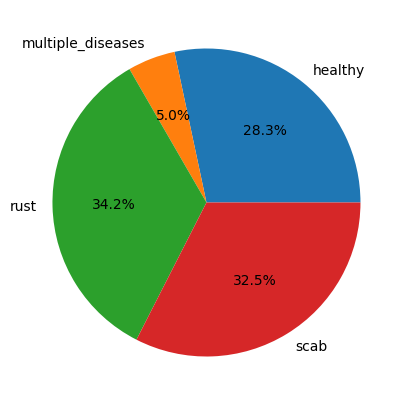

In [61]:
# target 값들의 분포 확인 
healthy = train.loc[train['healthy'] == 1]
multiple_diseases = train.loc[train['multiple_diseases'] == 1]
rust = train.loc[train['rust'] == 1]
scab = train.loc[train['scab'] == 1]

import matplotlib as mpl 
import matplotlib.pyplot as plt 

mpl.rc('font', size = 10)
plt.figure(figsize = (5,5))

label = ['healthy', 'multiple_diseases', 'rust', 'scab']

plt.pie([len(healthy), len(multiple_diseases), len(rust), len(scab)], 
        labels = label, autopct = '%.1f%%' )

- multiple_diseases = 1인 데이터가 상대적으로 매우 적다.
- 훈련/검증 데이터 분리할 때, 이점을 고려하여 비율에 맞춰 추출해야 한다. 

In [62]:
# image check 함수제작 
import cv2
import matplotlib.gridspec as gridspec 

def show_image(img_ids, rows=2, cols=3): 
    assert len(img_ids) <= rows*cols  #이미지 갯수가 rows x cols 보다 적으면 에러 발생 
    plt.figure(figsize=(10,6))
    grid = gridspec.GridSpec(rows, cols)
    
    for idx, img_id in enumerate(img_ids): 
        img_path = f'/kaggle/input/plant-pathology-2020-fgvc7/images/{img_id}.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax= plt.subplot(grid[idx])
        ax.imshow(image)

In [63]:
# 각 타겟값별 마지막 n개 이미지 
num_of_imgs = 6

last_healthy_img_ids = healthy['image_id'][-num_of_imgs:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-num_of_imgs:]
last_rust_img_ids = rust['image_id'][-num_of_imgs:]
last_scab_img_ids = scab['image_id'][-num_of_imgs:]

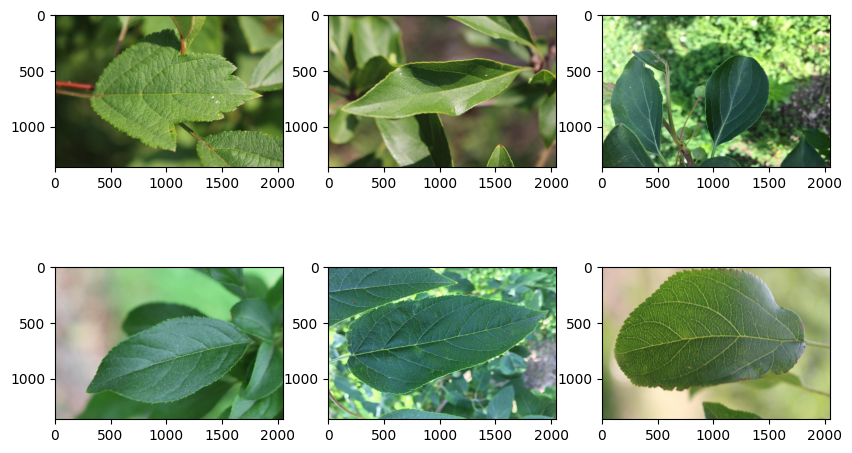

In [64]:
#건강한 잎사귀
show_image(last_healthy_img_ids)

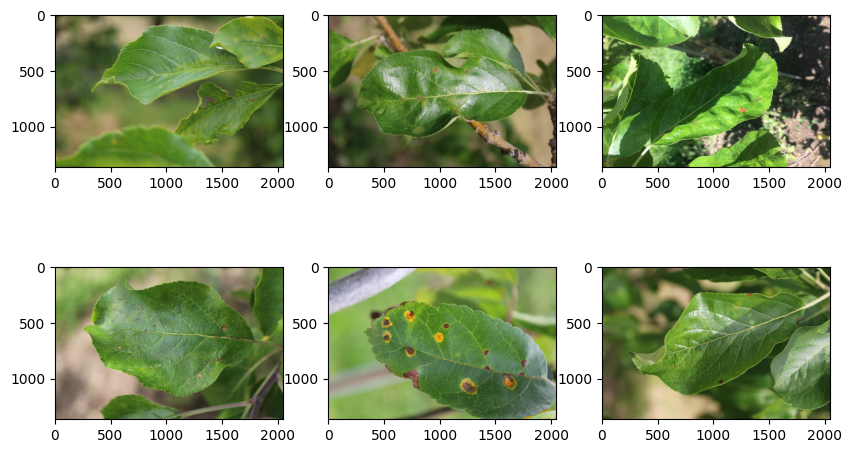

In [65]:
#다수의 질병 
show_image(last_multiple_diseases_img_ids)

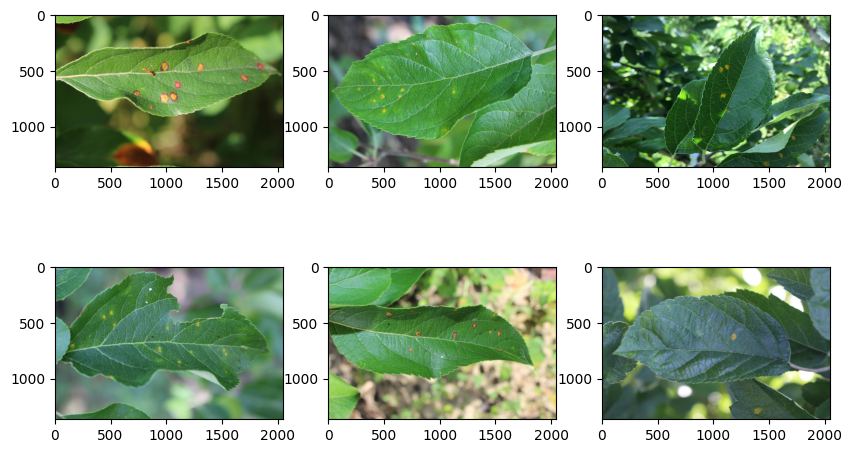

In [66]:
#녹병 
show_image(last_rust_img_ids)

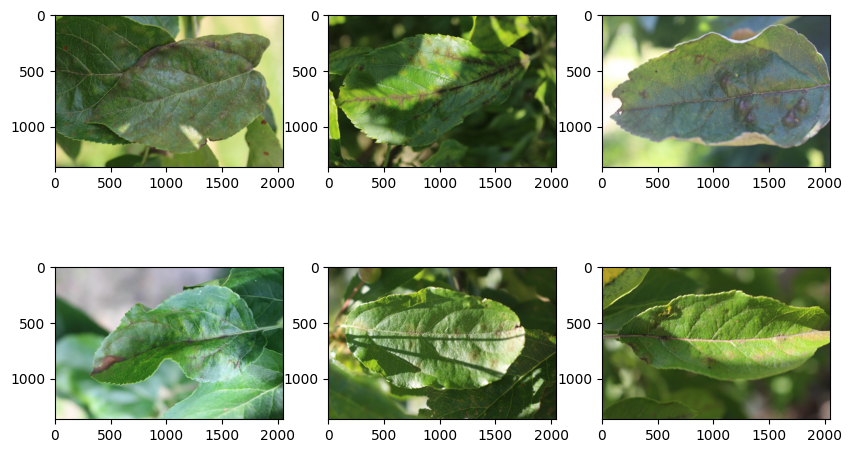

In [67]:
#곰팡이병 
show_image(last_scab_img_ids)

--- 
### Baseline model 
- 사전훈련된 모델 사용 (efficientnet-b7)
- 다양한 변환기를 사용하여 데이터 증강
- AdamW 옵티마이저 사용 
--- 

In [68]:
# 0.데이터 로딩 
# 1.시드고정 
import torch 
import random 
import os 
import numpy as np 

seed = 50 
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

# 3.GPU setting 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [69]:
# 4.train/valid data split : 4개 target변수들의 비율에 맞춰 층화추출 
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, test_size = 0.1, 
                                stratify = train[['healthy', 'multiple_diseases', 'rust', 'scab']], 
                                random_state = 50)

In [70]:
# 5. data class define 
from torch.utils.data import Dataset 

class ImageDataset(Dataset): 
    #초기화 메서드 생성 (is_test = True/False ~ 테스트용/훈련&검증용 데이터셋을 만들려 할때 지정)
    def __init__(self, df, img_dir = './', transform = None, is_test = False): 
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform 
        self.is_test = is_test 
    #데이터셋 크기변환 
    def __len__(self): 
        return len(self.df)
    #인덱스(idx)에 해당하는 데이터 반환 
    def __getitem__(self, idx): 
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id + '.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #이미지 변환 
        if self.transform is not None: 
            #image = self.transform(image) <- torchvision 변환기 사용할 때는 이렇게, 아래는 albumentations를 사용하기 위함 
            image = self.transform(image=image)['image']
        #이미지가 테스트용이면 이미지만, 훈련/검증용이면 이미지와 타겟값 반환 
        if self.is_test: 
            return image 
        else : 
            #이미지가 훈련/검증용인 경우, 타겟값(healthy, multiple_disease, rust, scab)중 가장 큰값의 인덱스 할당 
            # eg.가장 큰값이 healthy -> 0, multiple_disease -> 1, rust -> 2, scab -> 3 
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label

In [71]:
# 6.이미지 변환기 정의 및 훈련/검증/테스트 데이터 변환  
# 이미지 크기, 밝기/명암, 상하좌우 대칭, 이동, 스케일링, 회전, 엠보싱/샤프닝/블러, 어파인, 정규화&텐서 변환 
import albumentations as A 
from albumentations.pytorch import ToTensorV2

transform_train = A.Compose([
    A.Resize(450, 650),   #원본 이미지가 가로가 긴 형태임 
    A.RandomBrightnessContrast(brightness_limit = 0.2, contrast_limit = 0.2, p = 0.3),  #밝기/명암이 -0.2 ~ +0.2의 값 & 적용확률 
    A.VerticalFlip(p=0.2), A.HorizontalFlip(p=0.5), 
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.3),       #이동조절 -0.1 ~ +0.1, 스케일조절 -0.2 ~ +0.2, 회전 -30 ~ +30도, 30% 확률로 적용
    A.OneOf([A.Emboss(p=1), A.Sharpen(p=1), A.Blur(p=1)], p=0.3),                       #엠보싱/샤프닝/블러 중 하나를 선택해서 30% 확률로 적용 
    A.PiecewiseAffine(p=0.3),                                                           #어파인(이미지 모양을 전체적으로 변경) 조절, 30% 
    A.Normalize(),                                                                      #정규화(torchvision을 쓸때는 transform.Normalize()를 사용함)
    ToTensorV2()                                                                        #이미지를 텐서 형태로 변환(torchvision을 쓸때는 transform.ToTensor()를 사용함)
])

#검증/테스트 데이터용 변환기 : 필수(크기조정, 정규화, 텐서화)만 적용 
transform_test = A.Compose([
    A.Resize(450, 650), 
    A.Normalize(), 
    ToTensorV2()
])

/usr/local/lib/python3.10/dist-packages/albumentations/core/validation.py:45: UserWarning: This augmenter is very slow. Try to use ``ElasticTransformation`` instead, which is at least 10x faster.
  original_init(self, **validated_kwargs)


In [72]:
# 7. 데이터셋 생성 
# 멀티 프로세스 활용을 위해, 데이터로더 시드값 고정하고 제너레이터 생성 
img_dir = '/kaggle/input/plant-pathology-2020-fgvc7/images/'
dataset_train = ImageDataset(train, img_dir = img_dir, transform = transform_train)
dataset_valid = ImageDataset(valid, img_dir = img_dir, transform = transform_test)

#멀티프로세싱 환경에서 데이터 로더의 각 워커(worker)가 고유한 시드값을 갖도록 설정하여 난수 생성의 일관성을 유지
#torch.initial_seed()는 현재 워커의 초기 시드를 가져옵니다. & 이 값을 2**32로 나눈 나머지를 worker_seed로 사용합니다.
def seed_worker(worker_id): 
    worker_seed = torch.initial_seed() % 2**32
    random.seed(worker_seed)
    np.random.seed(worker_seed)
#PyTorch에서 난수 생성기를 제어하기 위한 객체를 만들고,생성기 g의 시드를 고정(이를 통해 멀티프로세싱 환경에서도 데이터 로더의 난수 생성이 일관성을 유지) 
g = torch.Generator()
g.manual_seed(0)

In [73]:
# 8. 데이터 로더 생성 
from torch.utils.data import DataLoader
batch_size = 4 

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=2)

In [74]:
# 9. 모델 임포트 
#!pip install efficientnet-pytorch==0.7.1
from efficientnet_pytorch import EfficientNet 

# num_classes는 최종 출력값의 갯수를 의미함 (여기서는 healty, multiple_disease, rust, scab의 4개)
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4)
model = model.to(device)

Loaded pretrained weights for efficientnet-b7


In [75]:
# 10. 손실함수와 옵티마이저 설정
import torch.nn as nn 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001 )

In [78]:
# 11. 모델 훈련&검증 : epoch 단위로 훈련과 성능검증을 반복함  
from sklearn.metrics import roc_auc_score 
from tqdm.notebook import tqdm
epochs = 5 

for epoch in range(epochs): 
    # 모델 설정 및 손실값 초기화 
    model.train()
    epoch_train_loss = 0 

    for images, labels in tqdm(loader_train): 
        images = images.to(device)
        labels = labels.to(device)
        #옵티마이저 초기화 
        optimizer.zero_grad() 
        #순전파 출력값과 손실값 계산 
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_train_loss += loss.item()
        #역전파 수행 및 가중치 갱신 
        loss.backward() 
        optimizer.step()
    
    print(f'epoch[{epoch+1}/{epochs}] - loss : {epoch_train_loss/len(loader_train):.4f}') 

    # 검증 : 모델을 평가상태로 설정, 손실값 초기화, 예측/실제값 저장용 리스트 생성  
    model.eval()
    epoch_valid_loss = 0 
    preds_list = []
    true_onehot_list = []

    with torch.no_grad(): #기울기 계산 비활성화
        #미니배치 단위로 검증 
        for images, labels in loader_valid: 
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item() 
            preds = torch.softmax(outputs.cpu(), dim=1).numpy()
            #실제값을 원-핫 인코딩 형태로 
            #true_onehot = torch.eye(4)[labels].cpu().numpy() 
            true_onehot = torch.eye(4, device=labels.device)[labels].cpu().numpy()

            # 실제&예측값 저장 
            true_onehot_list.extend(true_onehot)
            preds_list.extend(preds) 
            
    print(f'epoch[{epoch+1}/{epochs}] - valid loss : {epoch_valid_loss/len(loader_valid):.4f} / valid ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')

  0%|          | 0/410 [00:00<?, ?it/s]

epoch[1/5] - loss : 0.2544
epoch[1/5] - valid loss : 0.1722 / valid ROC AUC : 0.9694


  0%|          | 0/410 [00:00<?, ?it/s]

epoch[2/5] - loss : 0.1842
epoch[2/5] - valid loss : 0.4817 / valid ROC AUC : 0.9618


  0%|          | 0/410 [00:00<?, ?it/s]

epoch[3/5] - loss : 0.1393
epoch[3/5] - valid loss : 0.1665 / valid ROC AUC : 0.9753


  0%|          | 0/410 [00:00<?, ?it/s]

epoch[4/5] - loss : 0.1135
epoch[4/5] - valid loss : 0.1222 / valid ROC AUC : 0.9934


  0%|          | 0/410 [00:00<?, ?it/s]

epoch[5/5] - loss : 0.0770
epoch[5/5] - valid loss : 0.1837 / valid ROC AUC : 0.9649


In [80]:
# 12. 예측 

# 테스트용 데이터셋, 로더 생성 
dataset_test = ImageDataset(test, img_dir = img_dir, transform=transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size = batch_size, shuffle=False, worker_init_fn = seed_worker, generator=g, num_workers=2)

# 타겟확률 예측 
model.eval()
preds = np.zeros((len(test), 4))

with torch.no_grad(): 
    for i, images in enumerate(loader_test): 
        images = images.to(device)
        outputs = model(images)
        preds_parts = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds[i*batch_size:(i+1)*batch_size] += preds_parts

In [84]:
print(preds.shape) 
preds[:10]

(1821, 4)


array([[1.84261836e-02, 2.02807132e-03, 9.79326129e-01, 2.19623529e-04],
       [8.15561998e-06, 8.01757909e-04, 9.99117553e-01, 7.25457212e-05],
       [1.03402141e-04, 9.03855253e-05, 2.85050599e-04, 9.99521136e-01],
       [9.99856114e-01, 2.95110167e-05, 7.69596809e-05, 3.73511321e-05],
       [6.10615189e-06, 4.75581619e-04, 9.99516010e-01, 2.24998962e-06],
       [9.99171376e-01, 7.95477608e-05, 4.12411755e-04, 3.36729921e-04],
       [9.99716580e-01, 3.33737662e-05, 7.98540059e-05, 1.70225598e-04],
       [9.80223649e-06, 9.60813995e-05, 1.02991942e-06, 9.99893069e-01],
       [1.10674032e-03, 6.84687614e-01, 1.92131884e-02, 2.94992447e-01],
       [2.38141438e-05, 2.47334683e-04, 9.99716222e-01, 1.26468367e-05]])

In [86]:
## kaggle 결과 제출용 
submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds
submission.to_csv('submission.csv', index=False)